In [1]:
# Author: Van Hoan Do <vanhoan310@gmail.com>
# License: BSD 3 clause (C) 2020
from numpy import genfromtxt
import numpy as np 
import matplotlib
import pylab as plt
import pandas as pd
from Jvis import UMAP, JUMAP

In [2]:
def legend_without_duplicate_labels(ax, title_fz):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='center left', numpoints=1, ncol=1, fontsize=title_fz, markerscale=title_fz-4, frameon=False, bbox_to_anchor=(1, 0.5))

In [3]:
# read data
adt_matrix = np.genfromtxt('data/pbmc_nodoubletbycluser_minPts50_adt_pca_preprocessing_by_seurat.csv', delimiter=',');
rna_matrix = np.genfromtxt('data/pbmc_nodoubletbycluster_minPts50_rna_pca_preprocessing_by_seurat.csv', delimiter=','); 
method = 'CiteFuse' # 'CiteFuse'
method = 'Specter' # 'Specter'
if method == 'Specter':
    y = np.genfromtxt('data/pbmc_jointspecter_labels.csv', delimiter=',')
    cell_types = ["CD4+ T", "Naive CD4+ T", "FCGR3A+ Mono.", "CD14+ Mono.", 
            "CD4+ T", "CD8+ T", "CD8+ T", "CD4+ T", "B", "MK", "Effector CD8+ T", "NK"] #stable specter
else:
    y = np.genfromtxt('data/pbmc_citefuse_labels.csv', delimiter=',')
    cell_types = ["B", "CD8+ T", "Naive CD4+ T", "FCGR3A+ Mono.", "CD14+ Mono.", "NK", "CD4+ T", "CD4+ T", "CD8+ T", "Effector CD8+ T"] #citefuse
labels_true = y.astype(int)

In [4]:
dpi = 200
title_fz = 12
metrics = 'euclidean'
n_NN = 30
min_dist = 0.1
print("Metrics for UMAP: ", metrics)
colors_map = {"NK":'black', "Naive CD4+ T":'dodgerblue', "FCGR3A+ Mono.":'gold', "CD8+ T":'magenta', "CD14+ Mono.":'blue', 
                  "CD4+ T":'silver',   "MK":'#cab2d6', "B":'#fb9a99', "Effector CD8+ T":'#fdbf6f'} #"DC":'lime', "CD34+":'#fdbf6f', "CD16+ Mono.":'#a6cee3',
colors_map = {"NK":'gray', "Naive CD4+ T":'dodgerblue', "FCGR3A+ Mono.":'gold', "CD8+ T":'blue', "CD14+ Mono.":'silver', 
                  "CD4+ T":'red',   "MK":'#cab2d6', "B":'#fb9a99', "Effector CD8+ T":'#fdbf6f'} #"DC":'lime', "CD34+":'#fdbf6f', "CD16+ Mono.":'#a6cee3',

Metrics for UMAP:  euclidean


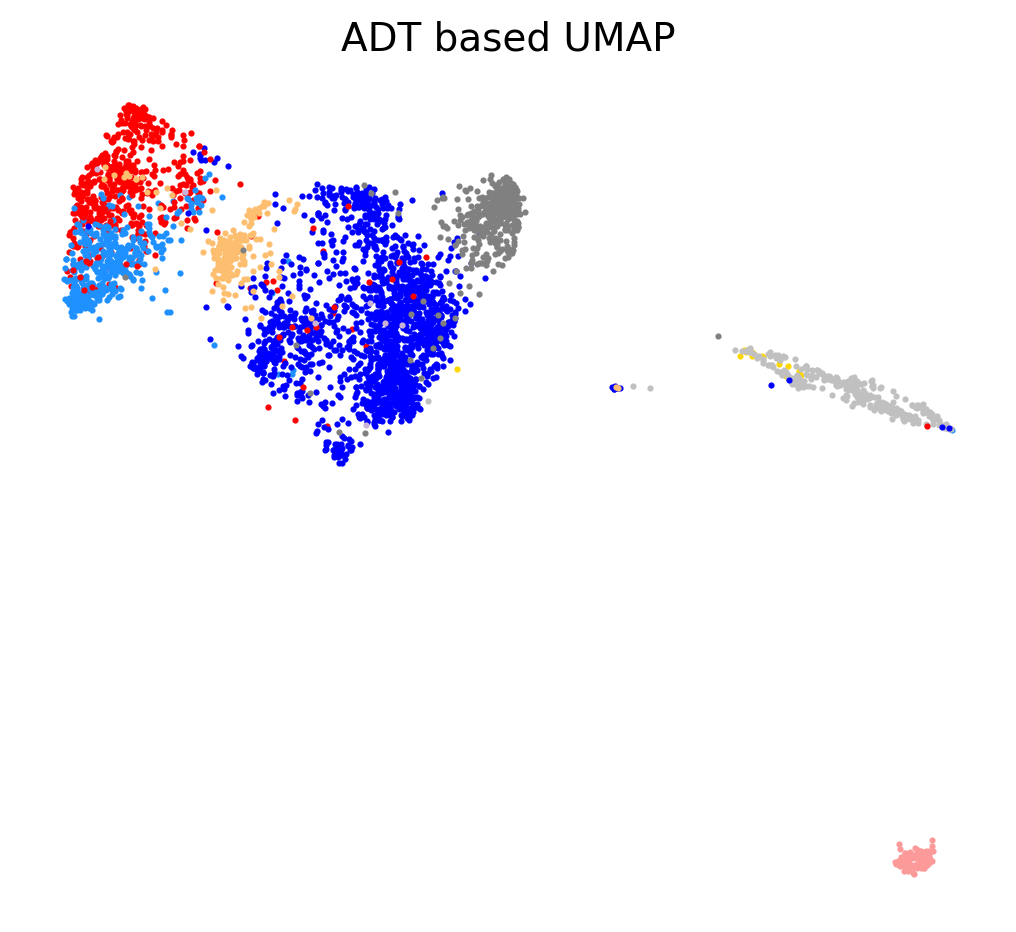

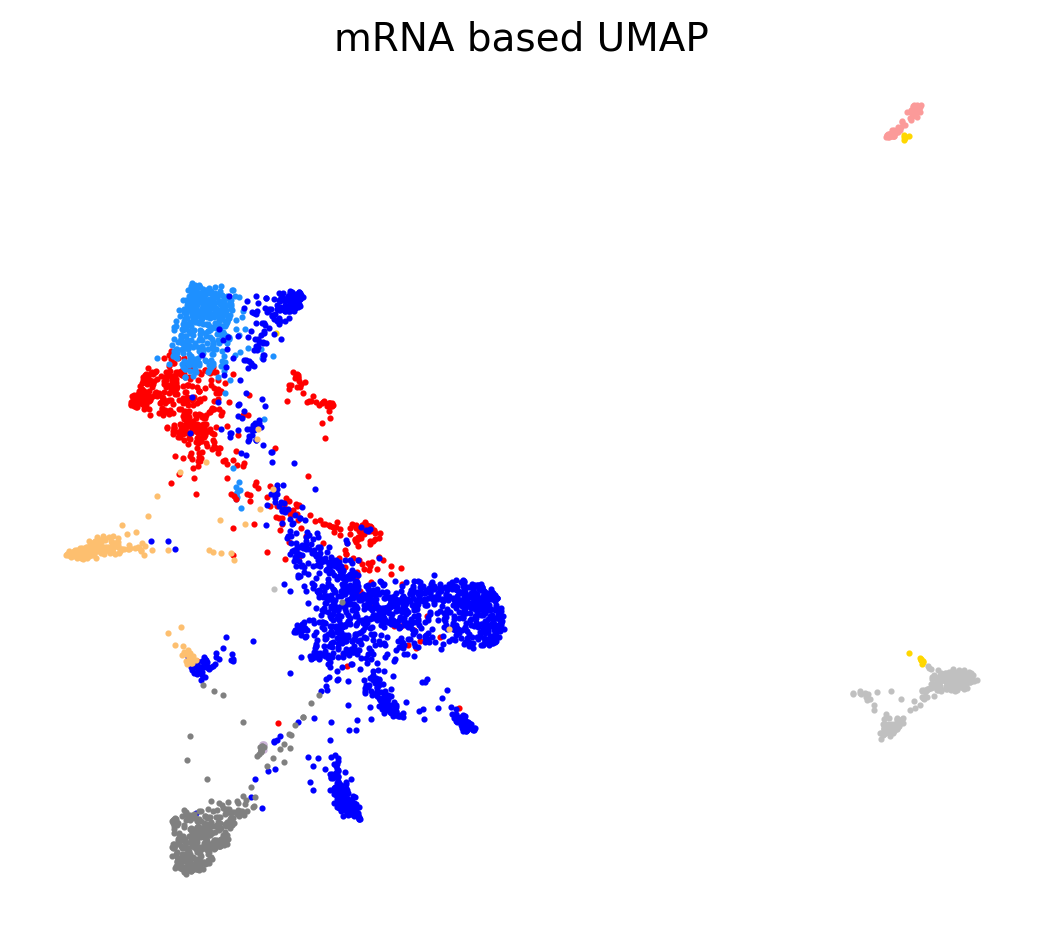

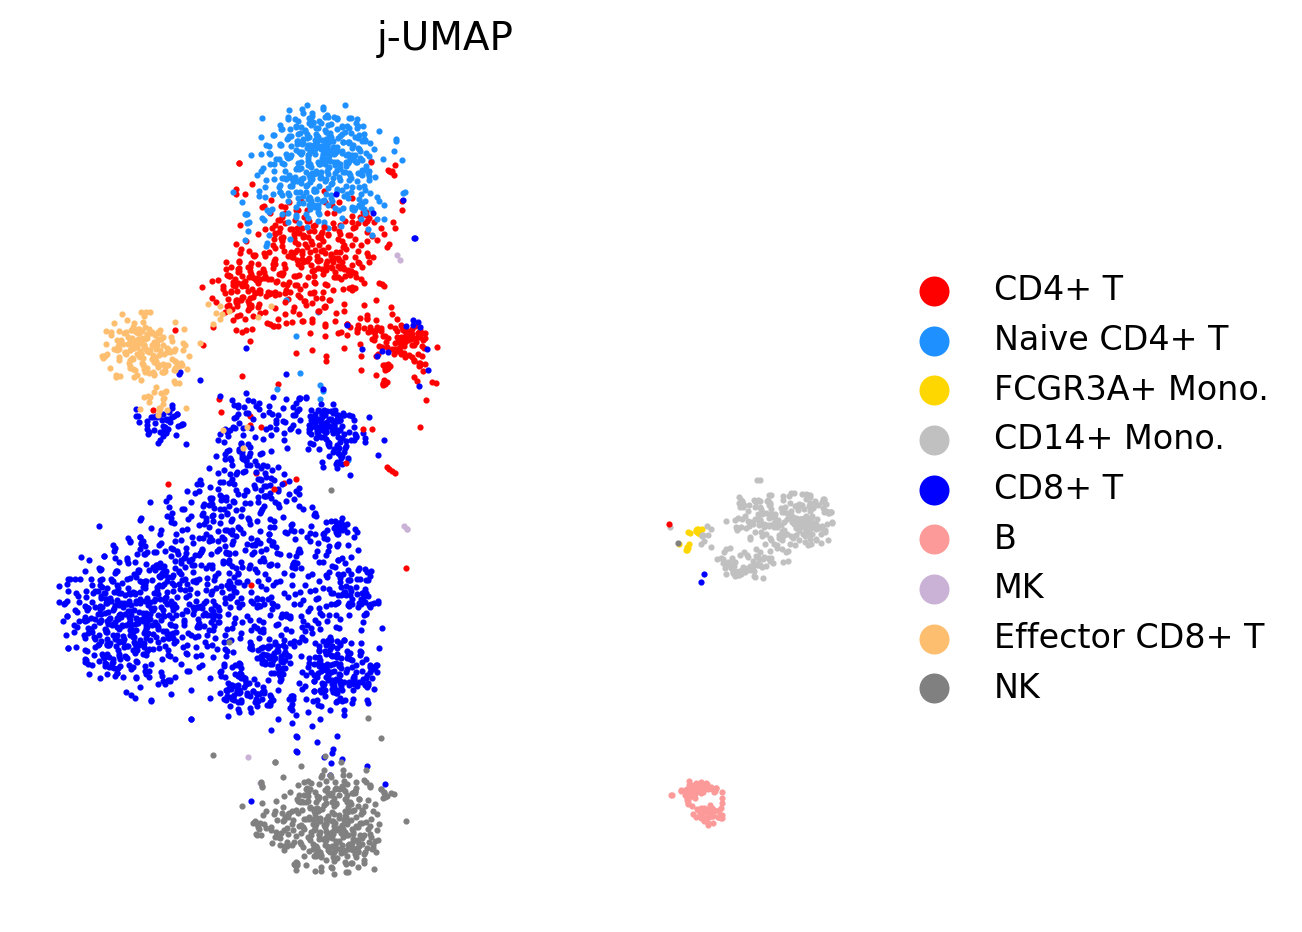

In [33]:
for alpha in [0.0, 1.0, 0.5]:
    if alpha==1.0:
        Z = UMAP(n_neighbors=n_NN, min_dist=min_dist, metric=metrics, repulsion_strength=0.1).fit_transform(rna_matrix)
    elif alpha==0.0:
        Z = UMAP(n_neighbors=n_NN, min_dist=min_dist, metric=metrics, repulsion_strength=0.1).fit_transform(adt_matrix)
    else:
#         Z = JUMAP(n_neighbors=n_NN, min_dist=min_dist, metric=metrics, repulsion_strength=0.5).fit_transform(X = {'adt': adt_matrix, 'rna': rna_matrix})
#         np.savetxt("jumap_pbmc.csv", Z, delimiter=",")
        Z = np.genfromtxt('jtsne_pbmc.csv', delimiter=',')

    data2 = pd.DataFrame({'x': Z[:,0], 'y': Z[:,1], 'label': labels_true-np.min(labels_true) + 1})
    
    figwidth = 7 if alpha==0.5 else 5.5
    fig, ax = plt.subplots(figsize=(figwidth, 5), dpi = dpi) # nolegend: 10, legend: 11
    for label in range(1, len(np.unique(labels_true))+1, 1):
        #add data points 
        i = label-1
        plt.scatter(x=data2.loc[data2['label']==label, 'x'], 
                    y=data2.loc[data2['label']==label,'y'], 
                    color=colors_map[cell_types[i]],  
                    alpha=1, s = 1.5, label = cell_types[i])
    if alpha == 1.0:
        plt.title("mRNA based UMAP", fontdict = {'fontsize' : title_fz+2})
    elif alpha == 0.0:
        plt.title("ADT based UMAP", fontdict = {'fontsize' : title_fz+2})
    else:
        plt.title("j-UMAP", fontdict = {'fontsize' : title_fz+2})
#             plt.legend(loc='center left', numpoints=1, ncol=1, fontsize=title_fz, markerscale=title_fz-2, frameon=False, bbox_to_anchor=(1, 0.5))
        legend_without_duplicate_labels(ax, title_fz)
    plt.tight_layout()
    plt.axis('off')
    if alpha == 1.0:
        plt.savefig('/data/hoan/plots/celltype/pbmc_'+method+'_on_RNAbasedUMAP_v2.pdf', dpi = dpi)
    elif alpha == 0.0:
        plt.savefig('/data/hoan/plots/celltype/pbmc_'+method+'_on_ADTbasedUMAP_v2.pdf', dpi = dpi)
    else:
        plt.savefig('/data/hoan/plots/celltype/pbmc_'+method+'_on_jointUMAP_v2.pdf', dpi = dpi)
    plt.show()

## Compute KNI and ARI metrics on 3 cell types: Naive CD4, Memory CD4 and CD8 from intesection of CiteFuse and Specter labels

In [5]:
# Specter label
specter_labels = np.genfromtxt('data/pbmc_jointspecter_labels.csv', delimiter=',').astype(int)
specter_labels = specter_labels - min(specter_labels) # reindex to start from 0
cell_types = ["CD4+CD27+ T", "Naive CD4+ T", "FCGR3A+ Mono", "CD14+ Mono", 
            "CD4+CD27-DR+ T", "CD8+CD27+ T", "CD8+CD27- T", "CD4+CD27-DR- T", "B", "MK", "Effector CD8+ T", "NK"] #stable specter
# Cell-type indices
# Naive CD4: 1
# Memory CD4: 0, 4, 7
# CD8: 5, 6 (10)

In [6]:
# Citefuse
citefuse_labels = np.genfromtxt('data/pbmc_citefuse_labels.csv', delimiter=',').astype(int)
citefuse_labels = citefuse_labels - min(citefuse_labels) # reindex to start from 0
cell_types2 = ["B", "CD8+CD27- T", "Naive CD4+ T", "FCGR3A+ Mono", "CD14+ Mono", "NK", "CD4+CD27+ T", "CD4+CD27- T", "CD8+CD27+ T", "Effector CD8+ T"] #citefuse
# Cell-type indices
# Naive CD4: 2
# Memory CD4: 6, 7
# CD8: 1, 8, (9)

In [7]:
naive_cd4 = (specter_labels==1) * (citefuse_labels==2)

In [8]:
memory_cd4 = ((specter_labels==0) + (specter_labels==4) + (specter_labels==7)) * ((citefuse_labels==6) + (citefuse_labels==7))

In [9]:
cd8 = ((specter_labels==5) + (specter_labels==6)+ (specter_labels==10)) * ((citefuse_labels==1) + (citefuse_labels==8) + (citefuse_labels==9))

In [10]:
subtypes_cells = naive_cd4 + memory_cd4 + cd8

In [11]:
sum(subtypes_cells)

2769

In [12]:
subtypes_labels_level = naive_cd4.astype(int) + 2* memory_cd4.astype(int) + 3*cd8.astype(int)

In [13]:
subtypes_labels = subtypes_labels_level[subtypes_labels_level>0]

In [14]:
len(subtypes_labels), subtypes_labels

(2769, array([1, 3, 3, ..., 3, 3, 3]))

In [15]:
# RNA based tSNE
sub_tsne_rna = UMAP(init='random').fit_transform(rna_matrix[subtypes_cells==1])

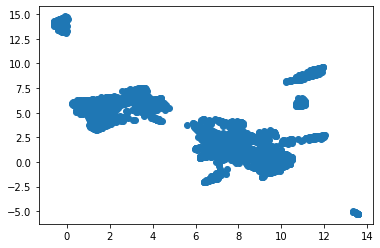

In [16]:
plt.scatter(sub_tsne_rna[:,0], sub_tsne_rna[:, 1])
plt.show()

In [18]:
from sklearn import metrics
#from c_index import (calc_c_index, calc_cindex_clusterSim_implementation)
metrics_name = 'silhouette_score'
def my_metric(X, labels):
#     D = metrics.pairwise_distances(X)
#     return calc_c_index(X, labels)
    if metrics_name == 'calinski_harabasz_score':
        return(metrics.calinski_harabasz_score(X, labels))
    elif metrics_name == 'silhouette_score':
        return(metrics.silhouette_score(X, labels))
    else:
        print("Not implemented yet!")

In [19]:
## Compute two metrics
from joint_metrics import *
kNN = 10
KNI_metrics = KNI(sub_tsne_rna, subtypes_labels, kNN)
# CARI_metrics = CARI(sub_tsne_rna, subtypes_labels)
print("KNI: ", KNI_metrics, ", Silhou: ", my_metric(sub_tsne_rna, subtypes_labels))

KNI:  0.9583604189237992 , Silhou:  0.11115281


/home/vanhoan310/miniconda3/envs/tsne/lib/python3.7/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [31]:
# ADT based tSNE
sub_tsne_adt = UMAP(init='random', random_state = 0).fit_transform(adt_matrix[subtypes_cells==1])

In [32]:
KNI_metrics = KNI(sub_tsne_adt, subtypes_labels, kNN)
# CARI_metrics = CARI(sub_tsne_adt, subtypes_labels)
print("KNI: ", KNI_metrics, ", Silhou: ", my_metric(sub_tsne_adt, subtypes_labels))

KNI:  0.9487540628385699 , Silhou:  0.51105714


In [33]:
# sub_joint_tsne = joint_tsne[subtypes_cells==1]
sub_joint_tsne = JUMAP().fit_transform(X = {'adt': adt_matrix[subtypes_cells==1], 'rna': rna_matrix[subtypes_cells==1]})

In [34]:
## Compute two metrics
KNI_metrics = KNI(sub_joint_tsne, subtypes_labels, kNN)
# CARI_metrics = CARI(sub_joint_tsne, subtypes_labels)
print("KNI: ", KNI_metrics, ", Silhou: ", my_metric(sub_joint_tsne, subtypes_labels))

KNI:  0.9860599494402311 , Silhou:  0.5253309
